In [1]:
import xarray as xr
import geopandas as gpd
import rioxarray
import pandas as pd
from datetime import date
from matplotlib import pyplot as plt
import numpy as np
import pyproj
import pickle
import matplotlib.dates as mdates

In [13]:
def reshapeDowy(series):
    tmpList = list()
    for y in years:
        ix = np.logical_and(datesClim >= np.datetime64(date(y,11,1)), datesClim < np.datetime64(date(y+1,7,1))) 
        tmpList.append(series.values[ix])
    df = pd.DataFrame(tmpList).transpose()
    df.columns = years
    return df

In [3]:
# Select period of interest 
endClimDate = '2021-07-01'
startClimDate = '1991-10-01'
dd = pd.DatetimeIndex([startClimDate, endClimDate]).year.values
years = np.arange(dd[0],dd[1])

In [8]:
# Lazily load all HS netcdf 
dsFullExtent = None
# correct CRS of UERRA dataset is 
crs = "+proj=lcc +lat_1=50 +lat_0=50 +lon_0=8 +a=6371229 +b=6371229 +units=m +x_0=330000 +y_0=880000"
dsFullExtent = xr.open_mfdataset('snd_UERRA_MESCAN_SURFEX_1961_2018_alps/snd_UERRA_MESCAN_SURFEX_day_*.nc')
dsFullExtent.rio.write_crs(crs, inplace=True)
datesSel = dsFullExtent['time'].sel(time=slice(startClimDate, endClimDate)) # exceeds 1984-2014
# reduce UERRA dataset to these dates
dsFullExtentSel = dsFullExtent.sel(time=datesSel)

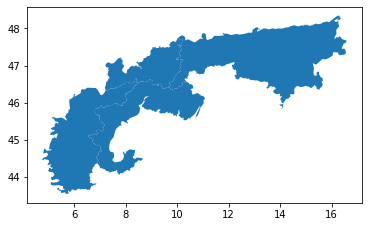

In [9]:
sf = gpd.reavaluesile('shp/AlpsCatchmentsEEAlonlat.shp')
sf.plot();

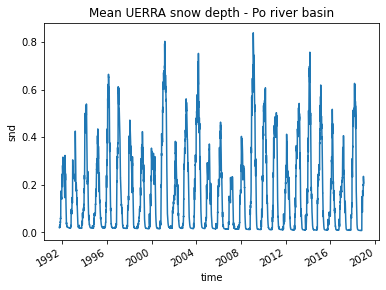

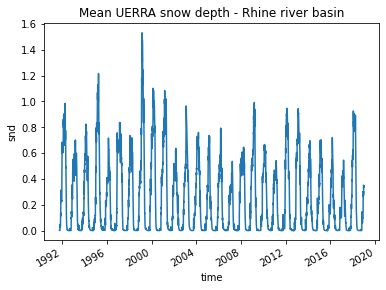

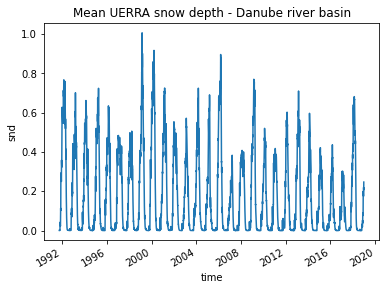

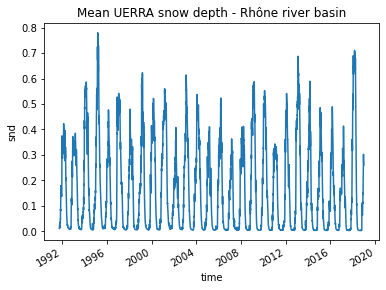

In [10]:
for ibv in range(0,len(sf)):
    fig = plt.figure()    
    bv = sf.loc[[ibv]]
    bvname = bv.BASINNAME.values[0]
    dsSel = dsFullExtentSel.rio.clip(bv.geometry.values, bv.crs)
    # plot mean snow depth
    dsSel.snd.mean(dim=('x','y')).plot()
    plt.title('Mean UERRA snow depth - {} river basin'.format(bvname));

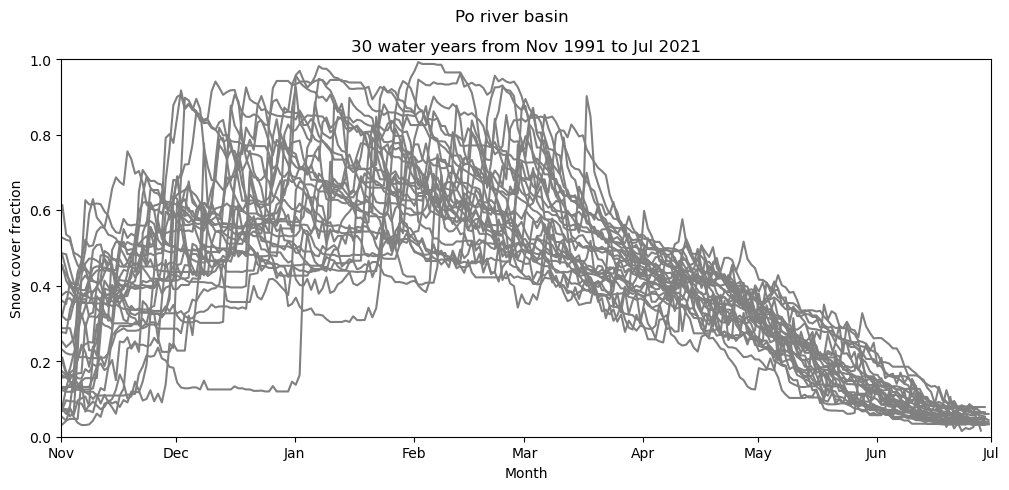

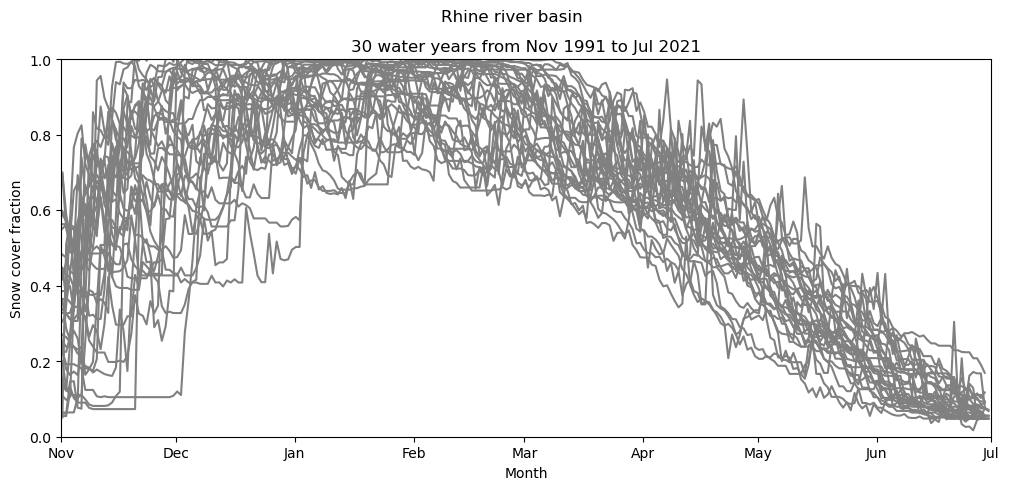

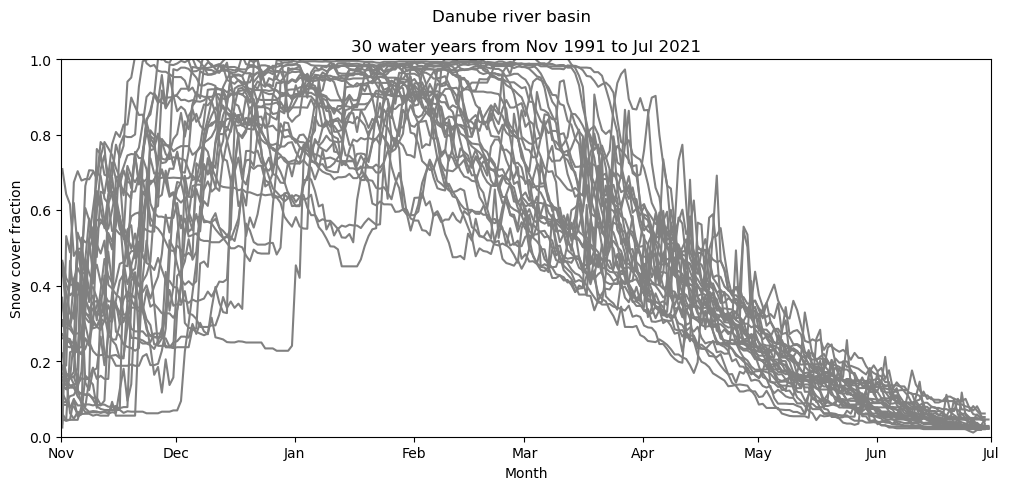

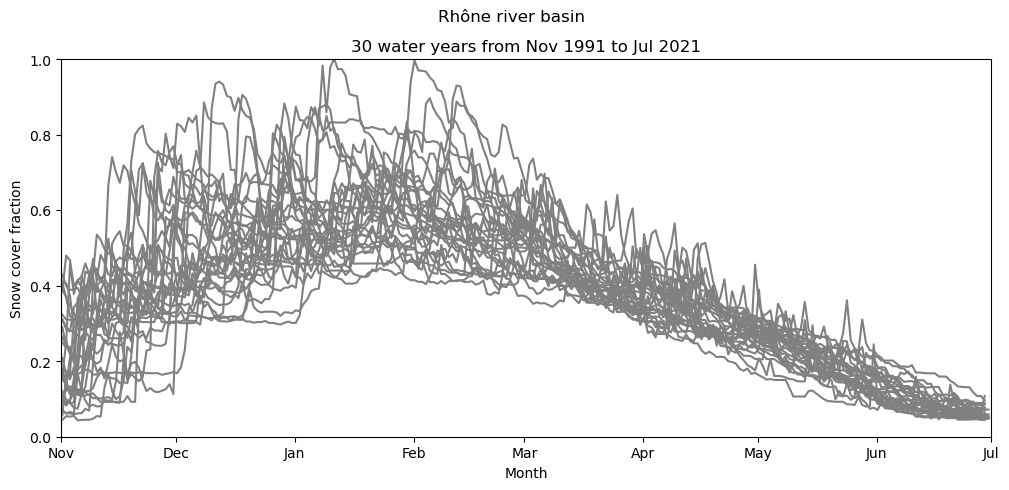

In [85]:
for ibv in range(0,len(sf)):
    bv = sf.loc[[ibv]]
    bvname = bv.BASINNAME.values[0]
    dsSel = dsFullExtentSel.rio.clip(bv.geometry.values, bv.crs)
    # Make X array with predictors
    X = dsSel['snd'].values.reshape(datesSel.size,-1)
    # remove nodata [TODO: APPLY MODIS AOI MASK]
    ix = np.all(np.isnan(X),axis=0)
    # This is the array of training data (snow depth of every cell)
    X = X[:,~ix]

    # load model
    f = '{}Scf01July5d'.format(bvname)
    mod = pickle.load( open( 'mod2{}.pickle'.format(f), "rb" ) )
    xmod = mod.predict(X)
    lastPredDate = datesSel[-1]

    # create date and scf arrays from Modis csv
    dfscf = pd.read_csv('Modis/{}.csv'.format(f), index_col=0, decimal='.')
    doy = dfscf.index
    dfdate = pd.DataFrame([pd.to_datetime(doy-1, unit='D', origin=str(y)) for y in dfscf.columns]).transpose()
    dfdate.index = dfscf.index
    dfdate.columns = dfscf.columns
    dates = dfdate.transpose().stack(dropna=False)
    scf = dfscf.transpose().stack(dropna=False)

    # index of modis dates taht will be used to complete the predicted series
    ix = np.logical_and(dates > lastPredDate.values, dates < np.datetime64(endClimDate))

    datesClim = pd.concat([
        pd.Series(datesSel), 
        pd.Series(dates[ix])]
        , axis=0, ignore_index=True)

    scfClim = pd.concat([
        pd.Series(xmod),
        pd.Series(scf[ix])]
        , axis = 0, ignore_index=True)

    # convert dates to millis (POSIX) to match 'system:time_start' in earth engine
    millis = pd.Series(datesClim, name='system:time_start')
    millis = millis.apply(lambda x: x.replace(hour=0).timestamp()*1000 )
    # convert dates at 6:00 to date only
    #dates = pd.Series(datesSel, name='dates').dt.date

    # concat scf
    outdf = pd.concat([millis, pd.Series(scfClim, name='scf')], axis = 1)
    outdf.set_index('system:time_start',inplace=True)
    outdf.to_csv('export/predictedScf_{}.csv'.format(bvname))

    # reshape to hydro years
    scfClimDowy = reshapeDowy(scfClim)
    datesClimDowy = reshapeDowy(datesClim)
    scfClimDowy.index = datesClimDowy.iloc[0:scfClimDowy.shape[0],0]

    fig = plt.figure(figsize=(12, 5), dpi=100);
    ax1 = fig.subplots(ncols=1)

    ax1.plot(scfClimDowy, color='grey')
    ax1.set_ylabel('Snow cover fraction')
    ax1.set_xlabel('Month')
    ax1.set_title('{} water years from Nov {} to Jul {}'.format(len(years),years[0],years[-1]+1))
    ax1.set_xlim([date(years[0],11,1), date(years[0]+1,7,1)])
    ax1.set_ylim([0,1])
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    fig.suptitle('{} river basin'.format(bvname));